In [3]:
# IMPORT LIBRARIES

import torch
import sak
import pickle
import cv2
import sak.torch.image.data
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pydicom
import sak
import glob
import os.path
import src.load_data
import scipy as sp
import math
import skimage.transform
import sak.torch.image.data.augmentation

In [21]:
### FUNCTIONS

def create_mask(x, gt_x, gt_y, line_width, x0):
    '''
    Create the binary mask from the GT, OJO with the line_width
    '''
    # CREATE MASK AND TILE
    min_size_x = 512
    window = 4
    sigma = 1.0

    # Boolean mask from the reference line to the curve position            #
    mask = np.zeros(x.shape[:2],dtype=bool)

    gt_x_full = gt_x.copy()
    gt_y_full = gt_y.copy()
    for i in range(gt_x.shape[0]-1):
        if gt_y[i+1]>gt_y[i]:
            s = 1
        else:
            s = -1
        for y in range(gt_y[i]+1,gt_y[i+1],s):
            gt_x_full = np.insert(gt_x_full,i+1,gt_x[i])
            gt_y_full = np.insert(gt_y_full,i+1,y)
    for i in range(-line_width//2,line_width//2):
        for j in range(-line_width//2,line_width//2):
            mask[gt_y_full+i,gt_x_full+j] = 1

    #                                                                       #
    ####################### CHOOSING A REPRESENTATION #######################

    # Crop image and ground truth so that it only represents GT span
    doppler_cropped         = x[:,gt_x-x0]
    mask_cropped            =    mask[:,gt_x-x0]

    # Repeat alongside x axis (2nd dimension to have at least min_size_x size)
    try:
        repetitions      = math.ceil(min_size_x/doppler_cropped.shape[1])
        envelope_y_tiled = np.concatenate(     [gt_y]*repetitions)
        mask_tiled       = np.concatenate(   [mask_cropped]*repetitions,axis=1)
        doppler_tiled    = np.concatenate([doppler_cropped]*repetitions,axis=1)
    except ZeroDivisionError:
        pass

    # Apply gaussian filter to smooth borders of tiling
    size_fundamental = doppler_tiled.shape[1]//repetitions
    locations = [(i+1)*size_fundamental-1 for i in range(repetitions-1)]
    for loc in locations:
        onset = loc-window+1
        offset = loc+window
        doppler_tiled[:,onset:offset] = sp.ndimage.gaussian_filter1d(
            doppler_tiled[:,onset:offset],sigma,axis=1
        )

    return doppler_tiled, mask_tiled, mask

def interpolar_crop(x, mask_tiled, doppler_tiled):

    # hay que interpolar, es decir recortar el eje x para que al hacer reshape no se distorsione
    shape = (256,512)
    # quiero que sea 256x512
    proporcion = shape[1] // shape[0]
    x_side = x.shape[0]*proporcion
    doppler_tiled_side = doppler_tiled.shape[0]*proporcion
    mask_tiled_side = mask_tiled.shape[0]*proporcion

    # cropping:
    x = x[:,0:x_side]
    x = cv2.resize(x,(512,256))[None,]
    x = x.squeeze()

    doppler_tiled = doppler_tiled[:,0:doppler_tiled_side]
    doppler_tiled = cv2.resize(doppler_tiled,(512,256))[None,]
    doppler_tiled = doppler_tiled.squeeze()

    mask_tiled = mask_tiled[:,0:mask_tiled_side]
    mask_tiled = skimage.transform.resize(mask_tiled,(256,512))[None,]
    mask_tiled = mask_tiled.squeeze()

    return x, doppler_tiled, mask_tiled

def get_output(x, model):

    x_torch = torch.tensor(x)[None,None]

    inputs = {'x' : x_torch.float()}

    sak.torch.image.data.augmentation.RescaleIntensity(inputs)

    with torch.no_grad():
        output = model(inputs)
        out_numpy = output['sigmoid'].cpu().detach().numpy().squeeze()

        return out_numpy[2,:,:]

### METRICS

def dice(inputs, targets, smooth=1):
    #flatten label and prediction tensors
    inputs = inputs.flatten()
    targets = targets.flatten()
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return dice

In [5]:
# LOAD THE MODEL

model = torch.load('C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/29/model_best.model')
model.state_dict()
model.eval()

ModelWrapper(
  (operation): wnet(
    (encoder): basenet(
      (e0): encoder_block(
        (conv): conv_block(
          (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu0): ReLU()
          (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout0): Dropout(p=0.25, inplace=False)
          (relu1): ReLU()
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout1): Dropout(p=0.25, inplace=False)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (e1): encoder_block(
        (conv): conv_block(
          (conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu0): ReLU()
          (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [7]:
# LOAD TEST SET
with open("C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/29/execution_info.pkl", "rb") as f:
    keys_test = pickle.load(f)["keys_test"]

In [24]:
# LOAD DATA FROM TEST SET

datadir = 'C:\\Users\\hp240\\Documents\\IAGO\\EBM\\TFG\\ALL_DOPPLER\\'

curves_x = sak.load_data(os.path.join(datadir,"x_coordinates.csv"))
curves_y = sak.load_data(os.path.join(datadir,"y_coordinates.csv"))

data = [datadir+i for i in keys_test]
curves_x_test = {i:curves_x[i] for i in keys_test}
curves_y_test = {i:curves_y[i] for i in keys_test}

dice_list = []

data_2 = data[:1]

for image in data_2:

    dicom = pydicom.dcmread(image)

    x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = src.load_data.get_frame(dicom,"doppler")

    x = dicom.pixel_array.copy()[y0:y1,x0:x1,]
    if dicom.get("PhotometricInterpretation", "RGB") in ['YBR_FULL', 'YBR_FULL_422']:
        x = src.load_data.convert_ybr_to_rgb(x)
    x = x[...,0] # to grayscale
    gt_x = curves_x_test[dicom.SOPInstanceUID] -x0
    gt_y = curves_y_test[dicom.SOPInstanceUID]

    doppler_tiled, mask_tiled, mask = create_mask(x, gt_x, gt_y, line_width = 40, x0=x0)
    x, doppler_tiled_2, mask_tiled_2 = interpolar_crop(x, mask_tiled, doppler_tiled)
    out_numpy = get_output(x, model)
    dice_list.append(dice(out_numpy, mask_tiled_2, smooth=1))

np.mean(dice_list)

c:\Users\hp240\Documents\IAGO\EBM\TFG\DopplerSegmentation_repository\src\models.py:180: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


0.39967076940148316

------ 

In [23]:

dicom = pydicom.dcmread(data[0])

x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = src.load_data.get_frame(dicom,"doppler")

x = dicom.pixel_array.copy()[y0:y1,x0:x1,]
if dicom.get("PhotometricInterpretation", "RGB") in ['YBR_FULL', 'YBR_FULL_422']:
    x = src.load_data.convert_ybr_to_rgb(x)
x = x[...,0] # to grayscale
gt_x = curves_x_test[dicom.SOPInstanceUID] -x0
gt_y = curves_y_test[dicom.SOPInstanceUID]

doppler_tiled, mask_tiled, mask = create_mask(x, gt_x, gt_y, line_width =20, x0=x0)
x, doppler_tiled_2, mask_tiled_2 = interpolar_crop(x, mask_tiled, doppler_tiled)
out_numpy = get_output(x, model)
dice_list.append(dice(out_numpy, mask_tiled_2, smooth=1))



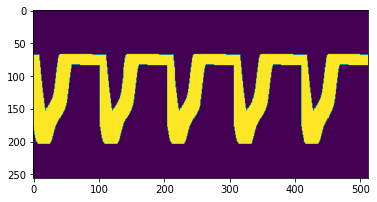

In [10]:
plt.imshow(mask_tiled_2)

In [11]:
## SIGUE DANDO RARO, EL PROBLEMA ESTA AQUÍ... creo que hay que fijarse en como hago la mask, y deshacerla desde ahi ##

vector = []
idxs = []

for i in range(mask_tiled.shape[1]):
    col = mask_tiled[:,i]
    tmp = False
    for idx, val in enumerate(col):
        if val != tmp:
            idxs.append(idx)
        tmp = val
    # miro si he encontrado o son todo 0:
    if len(idxs) == 0:
        idxs = [0,0]

    # salgo de la columna y calculo el valor:
    vector.append(sum(idxs)/2)

    idxs = []

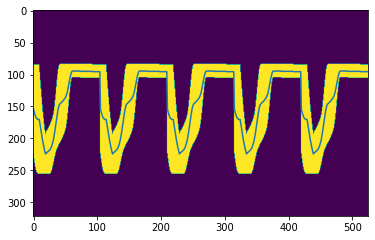

In [12]:
for ind, i in enumerate(vector):
    if i ==0:
        vector[ind] = None

plt.imshow(mask_tiled)
plt.plot(vector)

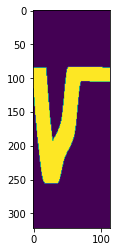

In [13]:
a = gt_x-x0-10

plt.imshow(mask[:,np.append(a,[a[-1] + i for i in range(1,10)])])
#plt.plot(gt_x-x0,gt_y)

In [14]:
mask_tiled       = np.concatenate(   [mask[:,np.append(a,[a[-1] + i for i in range(1,10)])]]*4,axis=1)

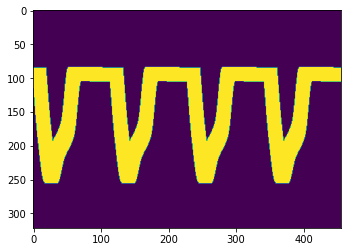

In [15]:
# COMENTAR SI ESTO PUEDE SER SIGNIFICATIVO!!!

plt.imshow(mask_tiled)